In [1]:
from fastai.vision.all import *

In [2]:
path = Path('/root/Documents/images')

In [3]:
path.ls()

(#144) [Path('/root/Documents/images/Amblyglyphidodon aureus'),Path('/root/Documents/images/Carassius auratus'),Path('/root/Documents/images/Abudefduf vaigiensis'),Path('/root/Documents/images/Cyprinella lutrensis'),Path('/root/Documents/images/Luxilus cornutus'),Path('/root/Documents/images/Chrysiptera taupou'),Path('/root/Documents/images/Phoxinus phoxinus'),Path('/root/Documents/images/Abudefduf sexfasciatus'),Path('/root/Documents/images/Notropis hudsonius'),Path('/root/Documents/images/Hesperoleucus symmetricus')...]

In [4]:
df_path = Path('/root/Documents/')

In [5]:
df = pd.read_csv(df_path/"csv/families3-stratified.csv")

In [6]:
df

,Order,Family,Subfamily,Genus,Specie,fname,is_valid
0,Perciformes,Centrarchidae,NaN,Ambloplites,Ambloplites rupestris,Ambloplites rupestris/25240275.jpg,False
1,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,Micropterus salmoides/65295609.jpg,False
2,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,Micropterus salmoides/47839127.jpg,False
3,Perciformes,Pomacentridae,Pomacentrinae,Abudefduf,Abudefduf abdominalis,Abudefduf abdominalis/14442685.jpg,False
4,Perciformes,Pomacentridae,Pomacentrinae,Chromis,Chromis multilineata,Chromis multilineata/49300790.jpg,False
...,...,...,...,...,...,...,...
86383,Perciformes,Pomacentridae,Pomacentrinae,Mecaenichthys,Mecaenichthys immaculatus,Mecaenichthys immaculatus/26249475.jpg,True
86384,Cypriniformes,Cyprinidae,Leuciscinae,Chrosomus,Chrosomus eos,Chrosomus eos/89045981.jpg,True
86385,Perciformes,Pomacentridae,Pomacentrinae,Pomacentrus,Pomacentrus coelestis,Pomacentrus coelestis/5496001.jpg,True
86386,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus carpio,Cyprinus carpio/41270267.jpg,True


In [7]:
weights_df = pd.read_csv(df_path/'csv/families3-weights.csv')
weights_family_df = pd.read_csv(df_path/'csv/families3-weights-family.csv')
weights_order_df = pd.read_csv(df_path/'csv/families3-weights-order.csv')
weights_genus_df = pd.read_csv(df_path/'csv/families3-weights-genus.csv')

In [8]:
weights_df

,Specie,Count,Weight
0,Abramis brama,300,1.999722
1,Abudefduf abdominalis,177,3.389360
2,Abudefduf bengalensis,299,2.006410
3,Abudefduf saxatilis,1423,0.421586
4,Abudefduf septemfasciatus,128,4.686849
...,...,...,...
139,Stegastes partitus,174,3.447797
140,Stegastes planifrons,178,3.370318
141,Systomus rubripinnis,587,1.022005
142,Telestes muticellus,144,4.166088


# Experiment 1: No Branch

In [9]:
fishes = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=ColReader(4),
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df, bs=64)

In [10]:
dls.train_ds, dls.valid_ds

((#69110) [(PILImage mode=RGB size=1024x768, TensorCategory(13)),(PILImage mode=RGB size=1024x768, TensorCategory(83)),(PILImage mode=RGB size=768x1024, TensorCategory(83)),(PILImage mode=RGB size=1024x915, TensorCategory(1)),(PILImage mode=RGB size=1024x768, TensorCategory(38)),(PILImage mode=RGB size=1024x683, TensorCategory(128)),(PILImage mode=RGB size=1024x768, TensorCategory(70)),(PILImage mode=RGB size=1024x642, TensorCategory(85)),(PILImage mode=RGB size=1024x683, TensorCategory(83)),(PILImage mode=RGB size=843x1024, TensorCategory(136))...],
 (#17278) [(PILImage mode=RGB size=768x1024, TensorCategory(83)),(PILImage mode=RGB size=1024x636, TensorCategory(83)),(PILImage mode=RGB size=1024x768, TensorCategory(52)),(PILImage mode=RGB size=1024x768, TensorCategory(42)),(PILImage mode=RGB size=768x1024, TensorCategory(69)),(PILImage mode=RGB size=653x672, TensorCategory(104)),(PILImage mode=RGB size=1024x768, TensorCategory(131)),(PILImage mode=RGB size=1024x1024, TensorCategory(69)

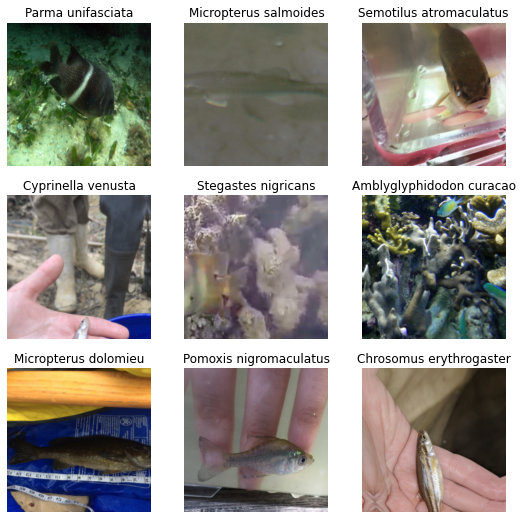

In [11]:
dls.show_batch(nrows=3, ncols=3)

In [12]:
class Resnet34CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.head = head
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [13]:
def custom_splitter(model):
    return [params(model.encoder),
            params(model.head)]

In [14]:
model = resnet34
body = create_body(model, cut=-2)
head = create_head(512*2,dls.c)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [15]:
model = Resnet34CustomModel(body, head)

In [16]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()

In [17]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=weights), metrics=accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [18]:
learn.summary()

Resnet34CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
ReLU                 64 x 64 x 84 x 84    0          False     
________________________________________

In [19]:
learn.fit(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.742393,2.282099,0.375622,07:39


In [20]:
learn.unfreeze()

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=9.12010818865383e-07)

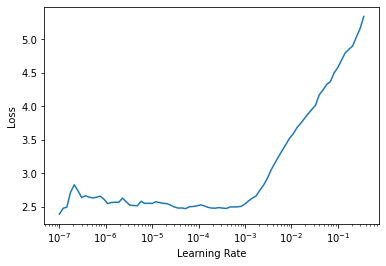

In [21]:
learn.lr_find()

In [22]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp1-fepochs1-uepochs10')

epoch,train_loss,valid_loss,accuracy,time
0,2.175799,1.922295,0.449473,07:26
1,2.007015,1.811669,0.470020,07:21
2,1.920804,1.747238,0.480669,07:21
3,1.875747,1.698101,0.491145,07:21
4,1.876154,1.657188,0.500289,07:22
5,1.768956,1.618541,0.508103,07:22
6,1.754207,1.584191,0.516958,07:21
7,1.660463,1.552040,0.520662,07:20
8,1.611795,1.523782,0.525234,07:19
9,1.569016,1.504333,0.531485,07:21


Path('models/families3-resnet34-exp1-fepochs1-uepochs10.pth')

In [18]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=weights), metrics=accuracy,
                       splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [19]:
learn = continue_training('families3-resnet34-exp1-fepochs1-uepochs10')

In [20]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp1-fepochs1-uepochs20')

epoch,train_loss,valid_loss,accuracy,time
0,1.556881,1.486768,0.538025,07:23
1,1.470244,1.470202,0.543813,07:15
2,1.493793,1.449919,0.553941,07:14
3,1.490269,1.434003,0.552668,07:15
4,1.410971,1.414572,0.555794,07:15
5,1.476319,1.394028,0.559498,07:15
6,1.394598,1.387712,0.562044,07:15
7,1.330849,1.369415,0.567195,07:15
8,1.329729,1.359537,0.575472,07:16
9,1.277744,1.348867,0.574372,07:16


Path('models/families3-resnet34-exp1-fepochs1-uepochs20.pth')

In [18]:
learn = continue_training('families3-resnet34-exp1-fepochs1-uepochs20')

In [19]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp1-fepochs1-uepochs30')

epoch,train_loss,valid_loss,accuracy,time
0,1.331320,1.332410,0.574546,07:30
1,1.276192,1.325161,0.576050,07:18
2,1.303143,1.316973,0.582185,07:18
3,1.227147,1.302216,0.581665,07:21
4,1.276997,1.293390,0.582012,07:20
5,1.169853,1.294036,0.584790,07:20
6,1.188002,1.279111,0.585311,07:20
7,1.173413,1.270410,0.590809,07:19
8,1.077395,1.269788,0.596365,07:20
9,1.210523,1.256027,0.596076,07:19


Path('models/families3-resnet34-exp1-fepochs1-uepochs30.pth')

In [ ]:
learn = continue_training('families3-resnet34-exp1-fepochs1-uepochs30')

In [20]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp1-fepochs1-uepochs40')

epoch,train_loss,valid_loss,accuracy,time
0,1.125662,1.249777,0.595960,07:20
1,1.070667,1.243861,0.595150,07:20
2,1.067497,1.243339,0.604989,07:21
3,1.087376,1.233246,0.607073,07:19
4,1.103500,1.225334,0.607825,07:19
5,1.068834,1.221560,0.610082,07:20
6,1.054824,1.217513,0.607304,07:19
7,1.045401,1.211663,0.610777,07:20
8,1.016419,1.205195,0.611471,07:21
9,1.003317,1.200372,0.616217,07:20


Path('models/families3-resnet34-exp1-fepochs1-uepochs40.pth')

In [19]:
learn = continue_training('families3-resnet34-exp1-fepochs1-uepochs40')

In [20]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp1-fepochs1-uepochs50')

epoch,train_loss,valid_loss,accuracy,time
0,0.993016,1.197132,0.618185,07:23
1,1.001871,1.200752,0.615175,07:13
2,0.949435,1.187927,0.623799,07:14
3,0.967037,1.189989,0.618995,07:12
4,1.018436,1.182669,0.622873,07:13
5,0.974418,1.182997,0.625535,07:13
6,0.926393,1.175126,0.625477,07:14
7,0.966800,1.176040,0.625883,07:14
8,0.980903,1.174417,0.627272,07:13
9,0.946424,1.171026,0.627793,07:13


Path('models/families3-resnet34-exp1-fepochs1-uepochs50.pth')

In [21]:
learn.export('families3-resnet34-exp1-fepochs1-uepochs50')

# Experiment 8: 1-Branch Family after block 2

In [10]:
model = resnet34
body = create_body(model, cut=-2)
body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [11]:
stem = body[0:4]
stem

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [12]:
block1, block2, block3, block4 = body[4], body[5], body[6], body[7]
block1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [13]:
head = create_head(512*2,dls.c)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=144, bias=False)
)

In [14]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse1_label = o['Family']
    return [coarse1_label, fine_label]

In [15]:
class Resnet34CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.stem = encoder[0:4]
        self.block1 = body[4]
        self.block2 = body[5]
        self.branch1 = create_head(128*2, len(set(df['Family'])))
        self.block3 = body[6]
        self.block4 = body[7]
        self.head = head
    
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        coarse1_label = self.branch1(x)
        x = self.block3(x)
        x = self.block4(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse1_label': coarse1_label
               }

In [16]:
model = Resnet34CustomModel(body, head)

In [17]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [18]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [19]:
def custom_splitter(model):
    return [params(model.stem),
            params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.head)]

In [20]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [21]:
dls.train_ds, dls.valid_ds

((#69110) [(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(13), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(83), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(83), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x915, {'fine_label': TensorCategory(1), 'coarse1_label': TensorCategory(2)}),(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(38), 'coarse1_label': TensorCategory(2)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(128), 'coarse1_label': TensorCategory(1)}),(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(70), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x642, {'fine_label': TensorCategory(85), 'coarse1_label': TensorCategory(2)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(83), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=843x1024, {

In [22]:
dls.vocab, dls.vocab_coarse1

(['Abramis brama', 'Abudefduf abdominalis', 'Abudefduf bengalensis', 'Abudefduf saxatilis', 'Abudefduf septemfasciatus', 'Abudefduf sexfasciatus', 'Abudefduf sordidus', 'Abudefduf troschelii', 'Abudefduf vaigiensis', 'Acanthochromis polyacanthus', 'Acrossocheilus paradoxus', 'Alburnus alburnus', 'Alburnus arborella', 'Ambloplites rupestris', 'Amblyglyphidodon aureus', 'Amblyglyphidodon curacao', 'Amblyglyphidodon leucogaster', 'Amphiprion bicinctus', 'Amphiprion chrysopterus', 'Amphiprion clarkii', 'Amphiprion frenatus', 'Amphiprion melanopus', 'Amphiprion ocellaris', 'Amphiprion percula', 'Amphiprion perideraion', 'Amphiprion polymnus', 'Barbus barbus', 'Barbus plebejus', 'Campostoma anomalum', 'Candidia barbata', 'Carassius auratus', 'Carassius gibelio', 'Centrarchus macropterus', 'Chromis atripectoralis', 'Chromis chromis', 'Chromis cyanea', 'Chromis hypsilepis', 'Chromis margaritifer', 'Chromis multilineata', 'Chromis notata', 'Chromis punctipinnis', 'Chromis ternatensis', 'Chromis

In [23]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()

In [24]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse1_label'], targ['coarse1_label'])

In [25]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [38]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [39]:
learn.summary()

Resnet34CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
ReLU                 64 x 64 x 84 x 84    0          False     
________________________________________

In [40]:
learn.fit(1, 3e-3)
learn.save('families3-resnet34-exp8-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,3.658937,3.182054,0.336034,07:11


Path('models/families3-resnet34-exp8-fepochs1-uepochs0.pth')

In [27]:
learn = continue_training('families3-resnet34-exp8-fepochs1-uepochs0')

In [28]:
learn.unfreeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=1.3182567499825382e-06)

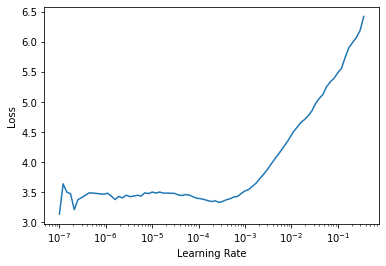

In [29]:
learn.lr_find()

In [30]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp8-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,2.849152,2.469098,0.462901,07:28
1,2.569211,2.273663,0.496643,07:19
2,2.335310,2.134442,0.524887,07:17
3,2.154217,2.014207,0.540572,07:17
4,2.035174,1.947443,0.568295,07:20
5,1.881727,1.894558,0.576340,07:20
6,1.776320,1.860075,0.599201,07:20
7,1.727392,1.843714,0.606320,07:17
8,1.560086,1.772403,0.617027,07:17
9,1.523207,1.758840,0.628545,07:17


Path('models/families3-resnet34-exp8-fepochs1-uepochs10.pth')

In [26]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [ ]:
learn = continue_training('families3-resnet34-exp8-fepochs1-uepochs10')

In [31]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp8-fepochs1-uepochs20')

epoch,train_loss,valid_loss,custom_accuracy,time
0,1.439977,1.741033,0.641220,07:18
1,1.385466,1.688913,0.642146,07:22
2,1.341950,1.723901,0.635259,07:22
3,1.241160,1.707321,0.657252,07:18
4,1.258091,1.663868,0.671548,07:17
5,1.175588,1.673064,0.661361,07:17
6,1.159777,1.615294,0.673342,07:17
7,1.084532,1.656368,0.663676,07:17
8,1.065728,1.631846,0.680982,07:19
9,1.014233,1.612017,0.688332,07:20


Path('models/families3-resnet34-exp8-fepochs1-uepochs20.pth')

In [27]:
learn = continue_training('families3-resnet34-exp8-fepochs1-uepochs20')

In [28]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp8-fepochs1-uepochs30')

epoch,train_loss,valid_loss,custom_accuracy,time
0,0.973343,1.655910,0.686943,07:42
1,0.962794,1.633759,0.691457,07:28
2,0.936360,1.661984,0.694756,07:27
3,0.880626,1.665101,0.705116,07:28
4,0.886851,1.662573,0.697592,07:27
5,0.880416,1.688982,0.702222,07:29
6,0.820929,1.632039,0.706737,07:28
7,0.811083,1.630146,0.713798,07:27
8,0.838040,1.681129,0.710209,07:28
9,0.822845,1.681193,0.716518,07:28


Path('models/families3-resnet34-exp8-fepochs1-uepochs30.pth')

In [ ]:
learn = continue_training('families3-resnet34-exp8-fepochs1-uepochs30')

In [29]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp8-fepochs1-uepochs40')

epoch,train_loss,valid_loss,custom_accuracy,time
0,0.786333,1.670933,0.711425,07:27
1,0.799840,1.708868,0.721553,07:27
2,0.762963,1.666436,0.717907,07:28
3,0.741183,1.638258,0.725026,07:30
4,0.709623,1.671137,0.717039,07:28
5,0.728511,1.675249,0.729135,07:28
6,0.705541,1.648949,0.731335,07:25
7,0.681991,1.691458,0.723868,07:27
8,0.652016,1.672984,0.731277,07:29
9,0.660211,1.715249,0.736254,07:28


Path('models/families3-resnet34-exp8-fepochs1-uepochs40.pth')

In [27]:
learn = continue_training('families3-resnet34-exp8-fepochs1-uepochs40')

In [28]:
learn.fit(10, slice(1e-6,1e-4))
learn.save('families3-resnet34-exp8-fepochs1-uepochs50')

epoch,train_loss,valid_loss,custom_accuracy,time
0,0.672321,1.689157,0.737933,07:32
1,0.628579,1.698227,0.740074,07:18
2,0.636261,1.709141,0.732608,07:20
3,0.623765,1.698840,0.736081,07:18
4,0.622964,1.735457,0.736949,07:19
5,0.589674,1.736139,0.741810,07:20
6,0.597167,1.755285,0.731971,07:20
7,0.596268,1.806348,0.728557,07:19
8,0.580301,1.706858,0.751881,07:20
9,0.608334,1.737213,0.735965,07:20


Path('models/families3-resnet34-exp8-fepochs1-uepochs50.pth')

In [29]:
learn.export('families3-resnet34-exp8-fepochs1-uepochs50')